In [7]:
""" ---------------------------------------------------------------------------
                             Annual data analyses

- This code produce the figures and data for the annual analyses. 

"""
"""----------------------------------------------------------------------------
Importing libraries used in this script
----------------------------------------------------------------------------"""
from logging import PercentStyle
from matplotlib.pyplot import savefig
from numpy.random import sample
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from matplotlib.pylab import savefig as save
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from statsmodels.stats.outliers_influence import summary_table
from xarray.core.duck_array_ops import count
import matplotlib.gridspec as gridspec
""" ---------------------------------------------------------------------------
defining functions used in this script
----------------------------------------------------------------------------"""


def outliers_index(data, m=3.5):
    """
    Returns true if a value is outlier
    
    :param int data: numpy array
    :param int m: # of std to include data 
    """
    import numpy as np
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d / mdev if mdev else 0.
    return ~(s < m)


def bootstrap(x, y, sample_weights, n, seed):
    """Bootstraping the weighted linear regression
        """
    np.random.seed(seed)
    # add a column of ones
    X = np.vstack([x, np.ones(len(x))]).T
    predicts = []
    params = []
    for j in range(0, n):
        sample_index = np.random.choice(range(0, len(y)), len(y))
        X_samples = X[sample_index]
        y_samples = y[sample_index]
        w_samples = sample_weights[sample_index]
        mod_wls = sm.WLS(y_samples, X_samples, weights=w_samples)
        res_wls = mod_wls.fit()
        predict = res_wls.predict(X)
        par = np.round(res_wls.params, 3)
        predicts.append(predict)
        params.append(par)
    predicts = np.array(predicts).T
    params = np.array(params).T
    return params, predicts


def binning(df, bins, var):
    """
    Fit OLS between variable of interest and DLCC

    :param dataframe df: pandas dataframe
    :param int bins: similar to bins argument in pandas.cut (bins intervals)
    :param str var: variable of interest   
    """
    # Binning data based on bins intervals
    df["bins"] = pd.cut(df["dlcc"], bins=bins, include_lowest=True)
    # group data based on bins and get the weighted mean of each bin
    bins_mean = df.groupby('bins').mean()

    # uncomment following linesto set the threshold on minimum number
    # of data in each bin since our bins are very small (0.001) we did not set
    counts = df.groupby('bins').count()["dlcc"]
    # bins_mean = bins_mean.where(counts >= 5)

    # Get rid of bins when there is zero data
    x = bins[1:][bins_mean[var].notnull()]
    y = bins_mean[var][bins_mean[var].notnull()].values
    counts = counts[bins_mean[var].notnull()]

    # X = sm.add_constant(x)
    # # Note it is weighted regression
    # mod_ols = sm.WLS(y, X, weights=counts)
    # res_ols = mod_ols.fit()
    # intercept, slope = np.round(res_ols.params, 3)

    # uncomment following linesto set the threshold on minimum number
    # of data in each bin since our bins are very small (0.001) we did not set
    # counts = df.groupby('bins').count()["dlcc"]
    # bins_mean = bins_mean.where(counts > 10)

    # intercept, slope = np.round(res_ols.params, 3)
    # intercept_bse, slope_bse = np.round(res_ols.bse, 3)
    # predicts = res_ols.predict(X)
    # pvalues = res_ols.pvalues
    # st, data, ss2 = summary_table(res_ols, alpha=0.05)
    # predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    out_list = [x, y, counts]
    return out_list


class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here


yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0, 0))
N_M = 10000  #Number of bootstrap
in_dir = ("/data/home/hamiddashti/nasa_above/outputs/")
out_dir = ("/data/home/hamiddashti/nasa_above/outputs/data_analyses/Annual/"
           "Albers/Figures_MS1/")



Analyzing EF
EF transition to --> DF
EF transition to --> Shrub
EF transition to --> Herbaceous
EF transition to --> Sparse
EF transition to --> Barren
EF transition to --> Fen
Analyzing DF
DF transition to --> Shrub
DF transition to --> Herbaceous
DF transition to --> Sparse
DF transition to --> Barren
DF transition to --> Fen
Analyzing Shrub
Shrub transition to --> Herbaceous
Shrub transition to --> Sparse
Shrub transition to --> Barren
Shrub transition to --> Fen
Analyzing Herbaceous
Herbaceous transition to --> Sparse
Herbaceous transition to --> Barren
Herbaceous transition to --> Fen
Analyzing Sparse
Sparse transition to --> Barren
Sparse transition to --> Fen
Analyzing Barren
Barren transition to --> Fen
Analyzing Fen
Analyzing EF
EF transition to --> DF
EF transition to --> Shrub
EF transition to --> Herbaceous
EF transition to --> Sparse
EF transition to --> Barren
EF transition to --> Fen
Analyzing DF
DF transition to --> Shrub
DF transition to --> Herbaceous
DF transition to

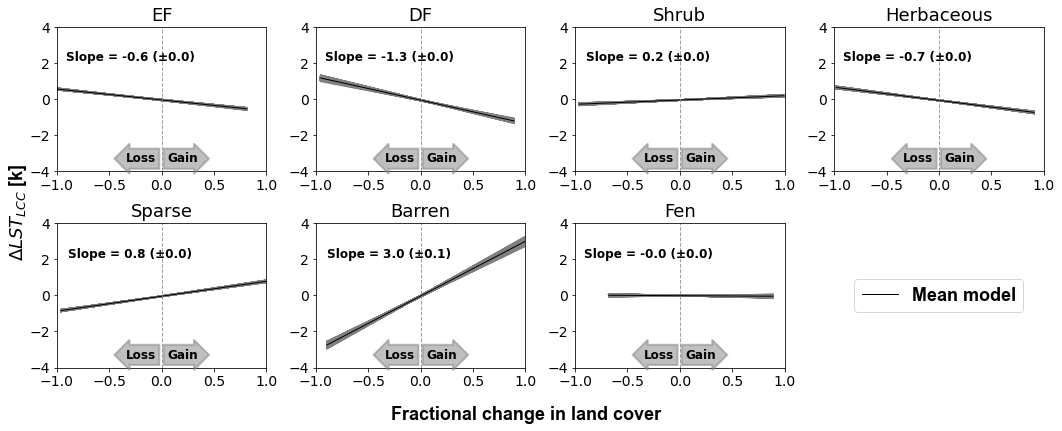

In [11]:
# out_dir = (
#     "/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/")
seasons = ["DJF", "MAM","JJA", "SON"]
# seasons = ["DJF"]
# season = seasons[3]

lst_slope_final = []
lst_std_final = []
for season in seasons:
    # The map of dLST due to LCC
    dlst_lcc = xr.open_dataarray(in_dir + (
        "Natural_Variability/Natural_Variability_Seasonal_Outputs/albers/" +
        season + "/dlst_lcc_" + season + ".nc"))
    dlst_total = xr.open_dataarray(in_dir + (
        "Natural_Variability/Natural_Variability_Seasonal_Outputs/albers/" +
        season + "/dlst_total_" + season + ".nc"))

    # This is the results of confusion table script
    ct = xr.open_dataset(in_dir + "Sensitivity/EndPoints/Seasonal/albers/" +
                         season + "/Confusion_Table_" + season + ".nc")

    dlst = ct["DLST_MEAN_LCC"]  # Changed LST due to LCC
    # weights = ct["WEIGHTS"]  # Weights based on area
    # weights = xr.Variable("ID", np.ones(len(dlst)))  # All weights are one
    # det = ct["DET_LCC"]  # Changed ET due to LCC
    # dalbedo = ct["DALBEDO_LCC"]  # Changed albedo due to LCC
    dlcc = ct["DLCC"]  # Fractional change in land cover
    normalized_confusion = ct["NORMALIZED_CONFUSION"]  # Normalized confusion
    I_dlst = outliers_index(dlst, 3.5)  # Outlier indices for dLST
    # I_dalbedo = outliers_index(dalbedo, 3.5)  # Outlier indices for dalbedo
    # I_det = outliers_index(det, 3.5)  # Outlier indices for det

    # Remove outliers based on indices
    dlst_clean = dlst.where(I_dlst == False)

    # dalbedo_clean = dalbedo.where((I_dlst == False) & (I_dalbedo == False)
    #                               & (I_det == False))
    # det_clean = det.where((I_dlst == False) & (I_dalbedo == False)
    #                       & (I_det == False))

    # weights_clean = weights.where(I_dlst == False)
    # dlcc_clean = dlcc.where((I_dlst == False) & (I_dalbedo == False)
    #                         & (I_det == False))
    # normalized_confusion_clean = normalized_confusion.where((I_dlst == False)
    #                                                         & (I_dalbedo == False)
    #                                                         & (I_det == False))

    dlcc_clean = dlcc
    normalized_confusion_clean = normalized_confusion

    palette = sns.color_palette("tab10")  # Color palette for plots
    lc_names = [
        "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen", "Bog",
        "Shallow_Littoral", "Water"
    ]

    # Figure 2 of the manuscript (Main LST plot)
    plt.close()
    fig, axs = plt.subplots(2,
                            4,
                            figsize=(15, 6),
                            facecolor='w',
                            edgecolor='k')
    axs = axs.ravel()
    axs_counter = 0
    t_list = []
    lst_slopes = np.zeros((len(lc_names), len(lc_names)))
    lst_slopes[:] = np.nan
    lst_std = np.zeros((len(lc_names), len(lc_names)))
    lst_std[:] = np.nan
    for i in range(len(lc_names)):
        # Skip the bog and shallow and litteral classes due to very sparse
        # data points
        if (i == 7) | (i == 8) | (i == 9):
            continue
        print(f"Analyzing {lc_names[i]}")
        dlcc_tmp_clean = dlcc_clean.isel(LC=i)
        df = pd.DataFrame({
            "dlst": dlst_clean,
            # "dalbedo": dalbedo_clean,
            # "det": det_clean,
            # "w": weights_clean,
            "dlcc": dlcc_tmp_clean
        })
        df = df.dropna()
        #----------------------------------------------
        # Bin data based on dLCC
        dlcc_bins = np.linspace(-1.001, 1, 2002)
        gian_loss_bins = binning(df=df, bins=dlcc_bins, var="dlst")
        # Scatter plot of the gain/loss
        # axs[axs_counter].scatter(x=out[0], y=out[1], color="gray")
        x = gian_loss_bins[0]
        y = gian_loss_bins[1]
        sample_weights = gian_loss_bins[2].values
        boot_reg = bootstrap(x=x,
                             y=y,
                             sample_weights=sample_weights,
                             n=N_M,
                             seed=0)
        params = boot_reg[0]
        predicts = boot_reg[1]
        axs[axs_counter].plot(x, predicts, color="gray", alpha=0.5)
        mean_predicts = np.mean(predicts, axis=1)
        axs[axs_counter].plot(x,
                              mean_predicts,
                              color="black",
                              linewidth=1,
                              label='Mean model')
        slope_mean = np.round(params[0, ].mean(), 1)
        slope_std = np.round(params[0, ].std(), 1)
        intercept_mean = np.round(params[1, ].mean(), 1)
        intercept_std = np.round(params[1, ].std(), 1)
        eq_text = (f"Slope = {slope_mean}" + " (\u00B1" +
                f"{slope_std})")
        axs[axs_counter].set_title(lc_names[i],fontsize=18)
        axs[axs_counter].tick_params(labelsize=14)
        axs[axs_counter].axvline(0, ls='--', c="gray", linewidth=1,alpha=0.75)
        axs[axs_counter].text(-0.3,
                              2.3,
                              eq_text,
                              horizontalalignment='center',
                              verticalalignment='center',
                              fontsize=12,
                              fontweight="bold",
                              color="black")
        axs[axs_counter].set_xlim(-1, 1)
        axs[axs_counter].set_ylim(-3, 3)
        axs[axs_counter].text(0.2,
                              -3.3,
                              "Gain",
                              ha="center",
                              va="center",
                              size=12,
                              color="black",
                              fontweight="semibold",
                              bbox=dict(boxstyle="rarrow,pad=0.3",
                                        fc="gray",
                                        ec="gray",
                                        alpha=0.5,
                                        lw=2))
        axs[axs_counter].text(-0.2,
                              -3.3,
                              "Loss",
                              ha="center",
                              va="center",
                              size=12,
                              fontweight="semibold",
                              color="black",
                              bbox=dict(boxstyle="larrow,pad=0.3",
                                        fc="gray",
                                        ec="gray",
                                        alpha=0.5,
                                        lw=2))
        axs[axs_counter].set_xlim(-1, 1)
        axs[axs_counter].set_ylim(-4, 4)
        # Now plot class transitions on top of the gain/loss
        # for k in range(2):
        for k in range(len(lc_names)):
            if (k == 7) | (k == 8) | (k == 9) | (k == i):
                continue
            # If a transition plotted in the previous subplots skip it.
            t_list.append(str(i) + str(k))
            if (str(k) + str(i)) in t_list:
                continue
            print(f"{lc_names[i]} transition to --> {lc_names[k]}")
            # transintion_loss is transition of class i to class k
            transintion_loss = normalized_confusion_clean[:, i, k]
            df_loss = pd.DataFrame({
                "dlst": dlst_clean,
                # "w": weights_clean,
                "dlcc": -transintion_loss
            })
            df_loss = df_loss.dropna()
            bins_loss = np.linspace(-1, 0, 1001)
            df_loss["bins"] = pd.cut(df_loss["dlcc"],
                                     bins=bins_loss,
                                     include_lowest=True)
            out_loss = binning(df=df_loss, bins=bins_loss, var="dlst")
            # transintion_gain is transition of class k to class i
            transintion_gain = normalized_confusion_clean[:, k, i]
            df_gain = pd.DataFrame({
                "dlst": dlst_clean,
                # "w": weights_clean,
                "dlcc": transintion_gain,
            })
            df_gain = df_gain.dropna()
            bins_gain = np.linspace(0, 1, 1001)
            out_gain = binning(df=df_gain, bins=bins_gain, var="dlst")
            # Concatenate the loss and gain transitions and fit a linear model
            x = np.append(out_loss[0], out_gain[0])
            if ((np.min(x) > -0.5) | (np.max(x) < 0.5)):
                slope_mean = 0.0
                slope_std = 0.0
                intercept_mean = 0.0
                intercept_std = 0.0
                lst_slopes[i, k] = 0.0
                lst_std[i, k] = 0.0
                continue
            y = np.append(out_loss[1], out_gain[1])
            sample_weights = np.append(out_loss[2].values, out_gain[2].values)
            boot_reg = bootstrap(x=x,
                                 y=y,
                                 sample_weights=sample_weights,
                                 n=N_M,
                                 seed=1)
            params = boot_reg[0]
            predicts = boot_reg[1]
            # axs[axs_counter].plot(x, predicts, color=palette[k], alpha=0.5)
            mean_predicts = np.mean(predicts, axis=1)
            # axs[axs_counter].plot(x,
            #                       mean_predicts,
            #                       color=palette[k],
            #                       linewidth=1,
            #                       label=lc_names[k])
            slope_mean = np.round(params[0, ].mean(), 1)
            slope_std = np.round(params[0, ].std(), 1)
            intercept_mean = np.round(params[1, ].mean(), 1)
            intercept_std = np.round(params[1, ].std(), 1)
            lst_slopes[i, k] = slope_mean
            lst_std[i, k] = slope_std
        axs_counter += 1

    # Sorting out the legend
    labels_handles = {
        label: handle
        for ax in fig.axes
        for handle, label in zip(*ax.get_legend_handles_labels())
    }

    # desired_legend_order = [
    #     "Mean model", "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen"
    # ]
    # reordered_labels_handles = {k: labels_handles[k] for k in desired_legend_order}
    # plt.legend(
    #     reordered_labels_handles.values(),
    #     reordered_labels_handles.keys(),
    #     bbox_to_anchor=(1, 1),
    # )
    bottom_right_ax = axs[-1]
    bottom_right_ax.clear()  # clears the random data I plotted previously
    bottom_right_ax.set_axis_off()  # removes the XY axes

    leg = plt.legend(
        labels_handles.values(),
        labels_handles.keys(),
        # bbox_to_anchor=(1, 1),
        loc='center',
        prop={
            "family": "Arial",
            "weight": "bold",
            "size": 18
        },
    )

    # for legobj in leg.legendHandles:
    #     legobj.set_linewidth(2.0)
    #     legobj.set_color("red")
    #     legobj.set_alpha(1)

    pltfont = {'fontname': 'Arial'}
    fig.supxlabel('Fractional change in land cover', fontsize=18, **pltfont,fontweight="bold")
    fig.supylabel("$\Delta LST_{LCC}$ [k]", fontsize=18, **pltfont,fontweight="bold")
    plt.tight_layout()
    save(out_dir + "Annual_gain_loss_LST_Albers_CI_all_" + season + ".png")
    lst_slope_final.append(-lst_slopes[0:6, 1:7])
    lst_std_final.append(lst_std[0:6, 1:7])



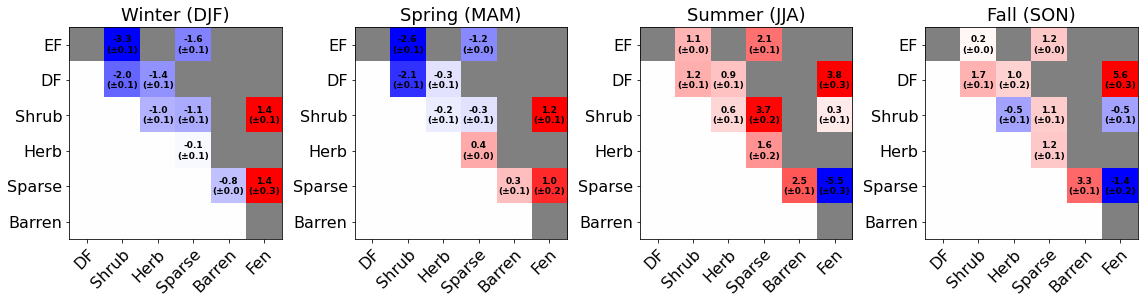

In [18]:
# ----------------------------------------------------------

# -----------------------------------------------------------------
#                              The heat map plot
# ----------------------------------------------------------------
import matplotlib as mpl
import matplotlib.colors as colors

initial_state = ["EF", "DF", "Shrub", "Herb", "Sparse", "Barren"]
final_state = ["DF", "Shrub", "Herb", "Sparse", "Barren", "Fen"]
data_slope = [
    lst_slope_final[0], lst_slope_final[1], lst_slope_final[2],
    lst_slope_final[3]
]
data_std = [
    lst_std_final[0], lst_std_final[1], lst_std_final[2], lst_std_final[3]
]
titles = ["Winter (DJF)", "Spring (MAM)","Summer (JJA)", "Fall (SON)"]

plt.close()
ar = 1.0  # initial aspect ratio for first trial
wi = 16  # width of the whole figure in inches, ...
hi = wi * ar
rows, cols = 1, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(wi, hi))

cmap = mpl.cm.get_cmap("bwr").copy()
cmap.set_bad(color='gray')
for k in range(0, rows * cols):
    ax = plt.subplot(gs[k])
    a = np.nan_to_num(data_slope[k], nan=0.0)
    b = np.where(data_slope[k] == 0, np.nan, a)
    c = np.ma.masked_where(np.isnan(b), b)
    c.filled(np.nan)
    # midnorm = MidpointNormalize(vmin=c.min(), vcenter=0, vmax=c.max())
    norm = colors.TwoSlopeNorm(vmin=c.min(), vcenter=0, vmax=c.max())
    im = ax.imshow(c, cmap=cmap, norm=norm)
    # im = ax.imshow(data_slope[k], cmap="bwr")
    ax.set_title(titles[k],fontsize=18)
    ax.set_xticks(np.arange(len(final_state)))
    ax.set_yticks(np.arange(len(initial_state)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(final_state,fontsize=16)
    ax.set_yticklabels(initial_state,fontsize=16)
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(initial_state)):
        for j in range(len(final_state)):
            if i > j:
                continue
            if data_slope[k][i, j] == 0:
                continue
            text = ax.text(j,
                           i,
                           str(data_slope[k][i, j]) + "\n(\u00B1" +
                           str(data_std[k][i, j]) + ")",
                           ha="center",
                           va="center",
                           color="black",
                           weight="heavy",
                           fontsize=9)

plt.draw()
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
y2x_ratio = (ymax - ymin) / (xmax - xmin) * rows / cols
fig.set_figheight(wi * y2x_ratio)
gs.tight_layout(fig)
plt.savefig(out_dir + "Heat_Map_Seasonal_revised.png")



